In [1]:
import warnings; warnings.simplefilter(action='ignore', category=FutureWarning)
import pyarrow as pa
import pyarrow.parquet as pq
from pyarrow import csv
from pyarrow import dataset as ds
import os
import numpy as np
import pandas as pd


import dask_jobqueue
import dask
import dask.dataframe as dd
import time

from distributed import Client
from contextlib import suppress 
import platform

PATH = "/d/hpc/projects/FRI/bigdata/students/mfmt/"
CSV_PATH = "/d/hpc/projects/FRI/bigdata/data/NYTickets"
PARQUET_FILENAME = "entire_1.parquet"
PARQUET_PATH = "/d/hpc/projects/FRI/bigdata/students/mfmt/parquet_aug"
DATA_AUG_PATH = "/d/hpc/home/mf4782/BD_project/data/"

files = os.listdir(CSV_PATH)
files = list([f for f in files if ".csv" in f])
files.sort()
print(files)

['2014.csv', '2015.csv', '2016.csv', '2017.csv', '2018.csv', '2019.csv', '2020.csv', '2021.csv', '2022.csv']


In [2]:
with suppress(Exception):
    client.shutdown()

cluster = dask_jobqueue.SLURMCluster(
            queue = 'all', 
            processes=1,
            cores=16, 
            memory='8GB',
            scheduler_options={'dashboard_address': ':21722'},
            death_timeout=120, # seconds
            walltime="1-01:30",
          )

client = Client(cluster, timeout="120s")#, memory_limit='8GB')
display(client.cluster)

/cvmfs/sling.si/modules/el7/software/Anaconda3/2021.11/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 21722 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34885 instead
  warnings.warn(


In [3]:
client.cluster.scale(16)
display(client.cluster)

In [63]:
client.shutdown()

In [18]:
#,
df = dd.read_parquet(PARQUET_PATH, columns=['Date','Summons Number'])
df = df.groupby("Date").count()
df = df.rename(columns=({'Summons Number':"Num Violations."}))

df_c = df.compute()
df_c["Date"] = df_c.index
df_c = df_c[~df_c["Date"].isnull()]
df_c.head(5)

,Num Violations.,Date
Date,,
1970-12-18,1,1970-12-18
1971-02-02,1,1971-02-02
1971-09-18,4,1971-09-18
1971-10-10,1,1971-10-10
1973-04-05,1,1973-04-05


In [19]:
#df_c = df_c.reset_index()[["Date", "Num Violations."]]
df_c["Date"] = pd.to_datetime(df_c["Date"])
df_c = df_c[(df_c["Date"].dt.year > 2012) & (df_c["Date"].dt.year < 2023)]
df_c.head(5)

,Num Violations.,Date
Date,,
2013-01-01,62,2013-01-01
2013-01-02,85,2013-01-02
2013-01-03,38,2013-01-03
2013-01-04,105,2013-01-04
2013-01-05,496,2013-01-05


In [37]:
def chunk(s):
    return s.value_counts()


def agg(s):
    return s.apply(lambda s: s.groupby(level=-1).sum())
    s = s._selected_obj
    return s.groupby(level=list(range(s.index.nlevels))).sum()


def finalize(s):
    level = list(range(s.index.nlevels - 1))
    return (
        s.groupby(level=level)
        .apply(lambda s: s.reset_index(level=level, drop=True).argmax())
    )

mode = dd.Aggregation('mode', chunk, agg, finalize)
columns = ["Street Name","Elementary","High School",'PoI']
arr = list([[] for c in columns])
df = dd.read_parquet(PARQUET_PATH, columns=['Date',"Street Name","Elementary","High School",'PoI',])
df = df.groupby("Date").agg(mode).compute()
print(df)

            Street Name  Elementary  High School  PoI
Date                                                 
1970-12-02            0           0            0    0
1971-05-20            0           0            0    0
1971-10-31            0           0            0    0
1971-11-06            0           0            0    0
1972-03-30            0           0            0    0
...                 ...         ...          ...  ...
2068-05-12            0           0            0    0
2068-06-18            0           0            0    0
2069-04-07            0           0            0    0
2069-06-19            0           0            0    0
2069-11-19            0           0            0    0

[4851 rows x 4 columns]


In [43]:
df["Date"] = pd.to_datetime(df.index)
df = df[(df["Date"].dt.year > 2012) & (df["Date"].dt.year < 2023)]
print(df.iloc[1])

Street Name                      1
Elementary                       0
High School                      0
PoI                              0
Date           2013-01-10 00:00:00
Name: 2013-01-10, dtype: object


In [46]:
df.drop('Date', inplace = True, axis = 1)
df_c.drop('Date', inplace = True, axis = 1)
df_c = df_c.merge(df, on="Date", how="left")
df_c.head(5)

,Num Violations.,Street Name,Elementary,High School,PoI
Date,,,,,
2013-01-01,62,NaN,NaN,NaN,NaN
2013-01-02,85,NaN,NaN,NaN,NaN
2013-01-03,38,NaN,NaN,NaN,NaN
2013-01-04,105,NaN,NaN,NaN,NaN
2013-01-05,496,0.0,137.0,39.0,91.0


In [48]:
w = dd.read_parquet(PARQUET_PATH, columns=['Date',"AirTemp"])
w = w.groupby("Date").mean().compute()
df_c = df_c.merge(w, on="Date", how="left")
df_c.head(5)

,Num Violations.,Street Name,Elementary,High School,PoI,AirTemp
Date,,,,,,
2013-01-01,62,NaN,NaN,NaN,NaN,NaN
2013-01-02,85,NaN,NaN,NaN,NaN,NaN
2013-01-03,38,NaN,NaN,NaN,NaN,NaN
2013-01-04,105,NaN,NaN,NaN,NaN,NaN
2013-01-05,496,0.0,137.0,39.0,91.0,NaN


In [49]:
df_c["y"] = df_c["Num Violations."] > df_c["Num Violations."].mean()
df_c.head(5)

,Num Violations.,Street Name,Elementary,High School,PoI,AirTemp,y
Date,,,,,,,
2013-01-01,62,NaN,NaN,NaN,NaN,NaN,False
2013-01-02,85,NaN,NaN,NaN,NaN,NaN,False
2013-01-03,38,NaN,NaN,NaN,NaN,NaN,False
2013-01-04,105,NaN,NaN,NaN,NaN,NaN,False
2013-01-05,496,0.0,137.0,39.0,91.0,NaN,False


In [62]:
df_c.to_csv("/d/hpc/home/mf4782/BD_project/data_ml/data.csv")

# Predicting days with high amounts of tickets

first we will predict days with high amounts of tickets

In [37]:
df_c = pd.read_csv("/d/hpc/home/mf4782/BD_project/data_ml/data.csv")
columns = ["Street Name","Elementary","High School",'PoI',"AirTemp"]
X = df_c[columns].values
X = np.nan_to_num(X)
y = df_c['y'].values

In [38]:
p = 0.7
split_margin = int(len(y) * p)
X_train = X[:split_margin, :]
X_test = X[split_margin:, :]
y_train = y[:split_margin]
y_test = y[split_margin:]
print(X)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0.]
 [0. 3. 4. 2. 0.]
 [0. 0. 0. 0. 0.]]


### Dask ML

First we will use Dask ML to learn a simple logistic regression

In [57]:
!pip install scikit-learn --upgrade
!pip install setuptools --upgrade

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.2 MB 3.7 MB/s eta 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.1.5 requires pyqt5<5.13, which is not installed.
spyder 5.1.5 requires pyqtwebengine<5.13, which is not installed.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.
anaconda-project 0.10.1 requires ruamel-yaml, which is not installed.


In [39]:
import sklearn
from dask_ml.linear_model import LogisticRegression
from dask_ml.metrics import accuracy_score
import time

def fit_model_dask(Xtr, ytr, Xt, yt):
    clf = LogisticRegression()
    tic = time.time()
    clf.fit(Xtr, ytr)
    toc = time.time()
    yp = clf.predict(Xt)
    acc = accuracy_score(yt, yp)
    return acc, toc - tic, clf
    
acc, t, clf = fit_model_dask(X_train, y_train, X_test, y_test)
print(f"On test set we achieved {acc*100}% accuracy in {t}s")

On test set we achieved 92.40862230552952% accuracy in 0.47928571701049805s


### Sklearn
Then we will try the partial fit by sklearn

In [40]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Perceptron
import joblib

def fit_model_sklearn(X,y):
    time_split = TimeSeriesSplit()
    clf = Perceptron(tol=1e-3)
    accs = []
    times = []
    ct = 0
    for tr, te in time_split.split(X):
        Xt, Xte = X[tr], X[te]
        yt, yte = y[tr], y[te]
        ct = ct + 1
        with joblib.parallel_backend("dask"):
            if ct == 1:
                tic = time.time()
                clf.fit(Xt, yt)
                toc = time.time()
            else:
                tic = time.time()
                clf.partial_fit(Xt, yt)
                toc = time.time()
            yp = clf.predict(Xte)
            acc = accuracy_score(yte, yp)
            accs.append(acc)
            times.append(toc-tic)
    return accs, times, clf

accs, times, clf = fit_model_sklearn(X,y)

print(accs)
print(times)
                

[0.7111486486486487, 0.643581081081081, 0.731418918918919, 0.5405405405405406, 0.6858108108108109]
[0.007689714431762695, 0.007752180099487305, 0.007929563522338867, 0.00839996337890625, 0.0085906982421875]


### XGBOOST
In the end we will fit xgboost

In [41]:
import xgboost
import dask.array as da

def fit_model_xgb(Xtr,ytr,Xt,yt):
    train_mat = xgboost.dask.DaskDMatrix(client, da.from_array(Xtr), da.from_array(ytr))
    test_mat = xgboost.dask.DaskDMatrix(client, da.from_array(Xt), da.from_array(yt))
    
    tic = time.time()
    output = xgboost.dask.train(
        client,
        {"verbosity": 3, "tree_method": "hist", "objective": 'binary:logistic'},
        train_mat,
        num_boost_round=4,
        verbose_eval=False,
        evals=[(test_mat, "test")],
    )
    toc = time.time()
    yp = xgboost.dask.predict(client, output, test_mat) > 0.5
    acc = accuracy_score(yt,yp)
    return acc,toc-tic, output, test_mat

acc, t, output, test_mat = fit_model_xgb(X_train, y_train, X_test, y_test)
print(f"On test set we achieved {acc*100}% accuracy in {t}s")

On test set we achieved 91.37769447047798% accuracy in 0.30095601081848145s


## Comparision

In [42]:
import pickle
import sys


scores = []

for i in range(10):
    acc, t, clf = fit_model_dask(X_train, y_train, X_test, y_test)
    size = sys.getsizeof(pickle.dumps(clf))
    scores.append(["Dask", size, t, acc])
    
    accs, times, clf = fit_model_sklearn(X,y)
    size = sys.getsizeof(pickle.dumps(clf))
    scores.append(["SKLearn", size, np.mean(times), np.mean(accs)])

    acc, t, clf, test_mat = fit_model_xgb(X_train, y_train, X_test, y_test)
    size = sys.getsizeof(pickle.dumps(clf))
    scores.append(["XGBOOST", size, t, acc])


In [43]:
df = pd.DataFrame(scores, columns = ["Model","Size","Time","Accuracy"])

[Text(0.5, 1.0, 'Size comparision for classification models')]

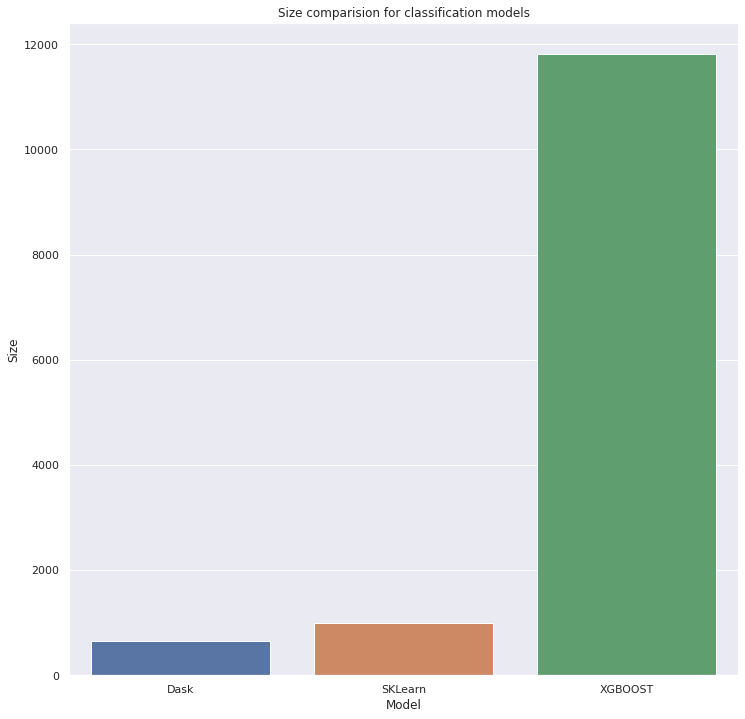

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(figsize=(12,12))
sns.barplot(data=df, x = 'Model', y = 'Size').set(title = "Size comparision for classification models")

[Text(0.5, 1.0, 'Time comparision for classification models')]

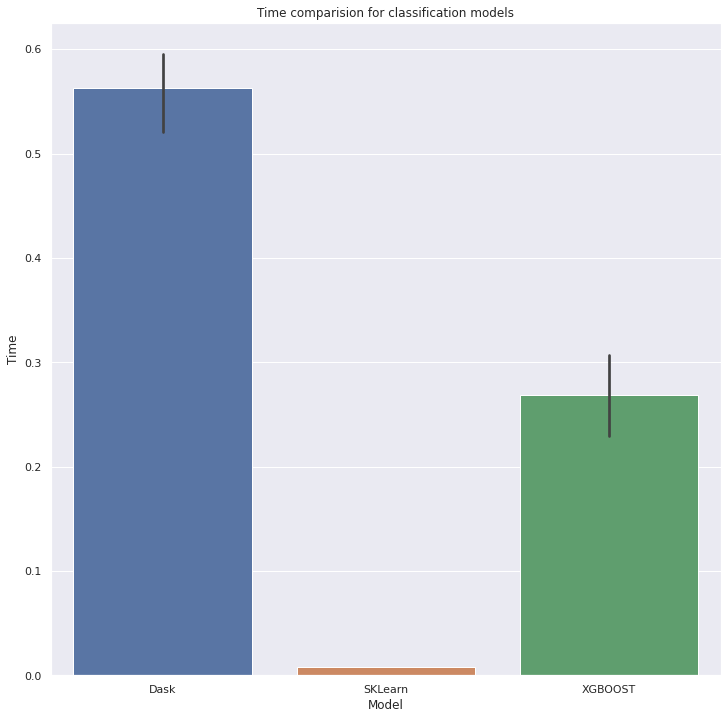

In [45]:
plt.figure(figsize=(12,12))
sns.barplot(data=df, x = 'Model', y = 'Time').set(title = "Time comparision for classification models")

[Text(0.5, 1.0, 'Accuracy comparision for classification models')]

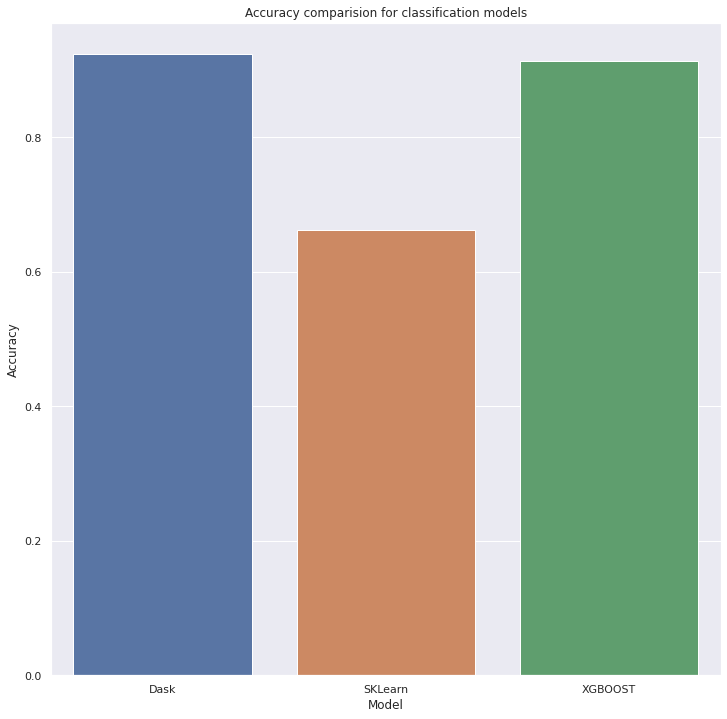

In [46]:
plt.figure(figsize=(12,12))
sns.barplot(data=df, x = 'Model', y = 'Accuracy').set(title = "Accuracy comparision for classification models")

# Prediction of air temp
We will try to predict air temp based on num of violations

In [17]:
df_c = pd.read_csv("/d/hpc/home/mf4782/BD_project/data_ml/data.csv")
df_c = df_c[~df_c["AirTemp"].isnull()]
columns = ["Street Name","Elementary","High School",'PoI',"Num Violations."]
X = df_c[columns].values
X = np.nan_to_num(X)
y = df_c['AirTemp'].values

In [18]:
p = 0.7
split_margin = int(len(y) * p)
X_train = X[:split_margin, :]
X_test = X[split_margin:, :]
y_train = y[:split_margin]
y_test = y[split_margin:]
print(X)

[[  4611.   7333.   6611.   6378.  86251.]
 [  1562.   3479.   3201.   3423.  15335.]
 [  4876.   7864.   7379.   7250.  85948.]
 ...
 [  3715.   8544.   8022.   7859. 103775.]
 [  6926.   8572.   8169.   8054. 104864.]
 [  9178.   8858.   8230.   8055.  85874.]]


### Dask ML

First we will use Dask ML to learn a simple linear regression

In [19]:
import sklearn
from dask_ml.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import time

def fit_model_dask(Xtr, ytr, Xt, yt):
    clf = LinearRegression()
    tic = time.time()
    clf.fit(Xtr, ytr)
    toc = time.time()
    yp = clf.predict(Xt)
    acc = mean_absolute_error(yt, yp)
    return acc, toc - tic, clf
    
acc, t, clf = fit_model_dask(X_train, y_train, X_test, y_test)
print(f"On test set we achieved {acc} MAE in {t}s")

On test set we achieved 5.872889512387099 MAE in 0.3387124538421631s


### Sklearn
Then we will try the partial fit by sklearn

In [20]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import SGDRegressor
import joblib

def fit_model_sklearn(X,y):
    time_split = TimeSeriesSplit()
    clf = SGDRegressor(tol=1e-5)
    accs = []
    times = []
    ct = 0
    for tr, te in time_split.split(X):
        Xt, Xte = X[tr], X[te]
        yt, yte = y[tr], y[te]
        ct = ct + 1
        with joblib.parallel_backend("dask"):
            if ct == 1:
                tic = time.time()
                clf.fit(Xt, yt)
                toc = time.time()
            else:
                tic = time.time()
                clf.partial_fit(Xt, yt)
                toc = time.time()
            yp = clf.predict(Xte)
            acc = mean_absolute_error(yte, yp)
            accs.append(acc)
            times.append(toc-tic)
    return accs, times, clf

accs, times, clf = fit_model_sklearn(X,y)

print(accs)
print(times)
                

[2.9575025263682016e+17, 4.1465349909884493e+18, 1.3230161757730378e+18, 6.659474329043329e+18, 1.0092230726193851e+18]
[0.0019769668579101562, 0.0006494522094726562, 0.0006051063537597656, 0.0006463527679443359, 0.0006442070007324219]


### XGBOOST

In [21]:
import xgboost
import dask.array as da

def fit_model_xgb(Xtr,ytr,Xt,yt):
    train_mat = xgboost.dask.DaskDMatrix(client, da.from_array(Xtr), da.from_array(ytr))
    test_mat = xgboost.dask.DaskDMatrix(client, da.from_array(Xt), da.from_array(yt))
    
    tic = time.time()
    output = xgboost.dask.train(
        client,
        {"verbosity": 3, "tree_method": "hist", "objective": 'reg:squarederror'},
        train_mat,
        num_boost_round=4,
        verbose_eval=False,
        evals=[(test_mat, "test")],
    )
    toc = time.time()
    yp = xgboost.dask.predict(client, output, test_mat)
    acc = mean_absolute_error(yt,yp)
    return acc,toc-tic, output

acc, t, clf = fit_model_xgb(X_train, y_train, X_test, y_test)
print(f"On test set we achieved {acc} MAE in {t}s")

On test set we achieved 17.972714392929525 MAE in 0.24209141731262207s


## Comparision

In [29]:
import pickle
import sys


scores = []

for i in range(10):
    acc, t, clf = fit_model_dask(X_train, y_train, X_test, y_test)
    size = sys.getsizeof(pickle.dumps(clf))
    scores.append(["Dask", size, t, acc])
    
    accs, times, clf = fit_model_sklearn(X,y)
    size = sys.getsizeof(pickle.dumps(clf))
    scores.append(["SKLearn", size, np.mean(times), np.mean(accs)])

    acc, t, clf = fit_model_xgb(X_train, y_train, X_test, y_test)
    size = sys.getsizeof(pickle.dumps(clf))
    scores.append(["XGBOOST", size, t, acc])

In [30]:
df = pd.DataFrame(scores, columns = ["Model","Size","Time","MAE"])

[Text(0.5, 1.0, 'Size comparision for regression models')]

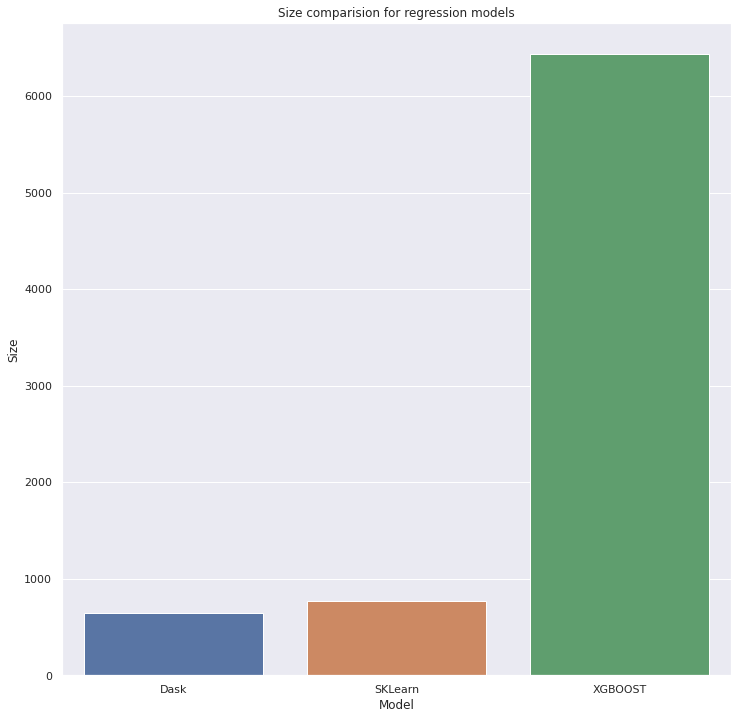

In [31]:
plt.figure(figsize=(12,12))
sns.barplot(data=df, x = 'Model', y = 'Size').set(title = "Size comparision for regression models")

[Text(0.5, 1.0, 'Time comparision for regression models')]

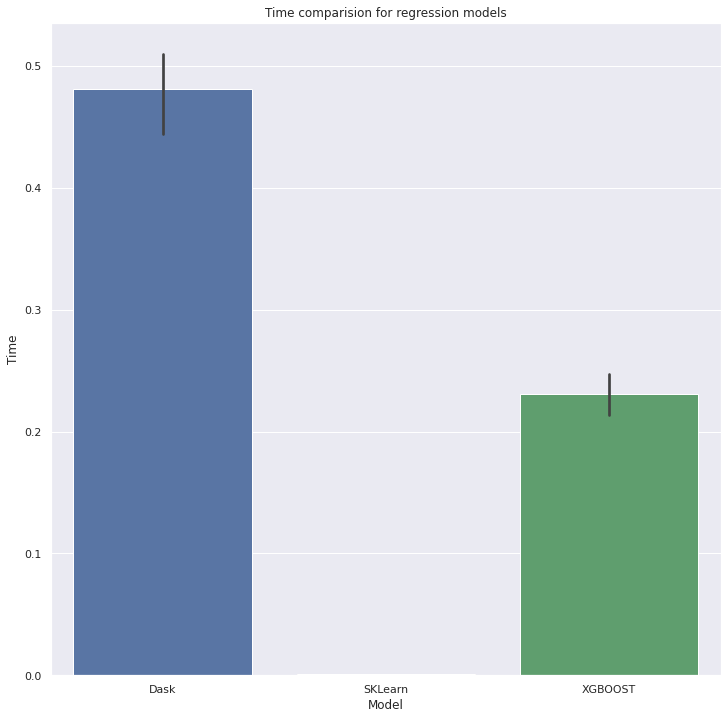

In [32]:
plt.figure(figsize=(12,12))
sns.barplot(data=df, x = 'Model', y = 'Time').set(title = "Time comparision for regression models")

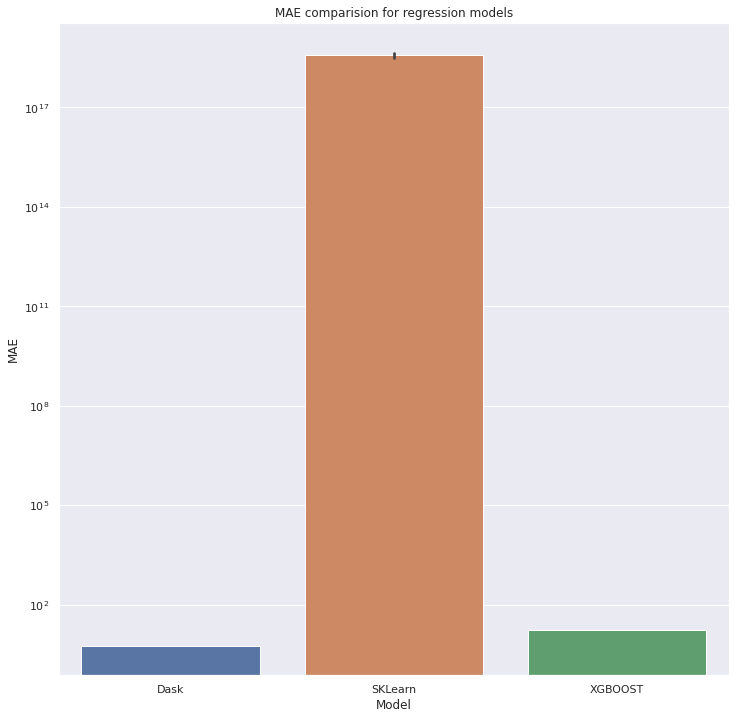

In [35]:
plt.figure(figsize=(12,12))
sns.barplot(data=df, x = 'Model', y = 'MAE').set(title = "MAE comparision for regression models")
plt.yscale("log")

In [33]:
df

,Model,Size,Time,MAE
0,Dask,645,0.328862,5.872890e+00
1,SKLearn,771,0.000989,3.061418e+18
2,XGBOOST,6436,0.239134,1.797271e+01
3,Dask,645,0.441636,5.872890e+00
4,SKLearn,771,0.000958,3.515606e+18
5,XGBOOST,6436,0.255171,1.797271e+01
6,Dask,645,0.478518,5.872890e+00
7,SKLearn,771,0.001261,4.726665e+18
8,XGBOOST,6436,0.227994,1.797271e+01
9,Dask,645,0.520960,5.872890e+00
